In [1]:
# required installation
# #!pip install -q qiskit==1.4.2 qiskit-aer==0.17.0 qiskit-algorithms==0.3.1 qiskit-optimization==0.6.1

In [58]:
# Necessary Imports
import re
import json
import copy
import time
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from pyqubo import Binary
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations

# Dwave Imports
from dwave.samplers import SimulatedAnnealingSampler

# Qiskit Libraries
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver

In [59]:
#from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [60]:
warnings.filterwarnings('ignore')

In [ ]:
class problem_formulation:
    def __init__(self, transactions, lengths, machines, bloc_trxns, c):
        # Initialize the scheduler with transactions, their lengths, machines, and blocking pairs
        self.transactions = transactions
        self.lengths = lengths
        self.machines = machines
        self.bloc_trxns = bloc_trxns
        self.n = len(transactions)
        self.k = len(machines)
        self.min_rt = sum(lengths)
        self.c = c
        self.transactions_dict = {transactions[i]: lengths[i] for i in range(self.n)}  # Initialize transactions_dict here
        self.R = self.calculate_runtime()  # Now safe to call calculate_runtime()
        self.runtime = self.k * self.R
        self.variables = self.define_variables()
        self.model = self.get_qubo()
        self.qubo = self.model.to_qubo()[0]
        print(self.R)

    def l(self, i):
        # Return the length of transaction i
        return self.lengths[i-1]

    def r(self, i):
        # Return the remaining time after transaction i
        return self.R - self.l(i)

    def left_machines(self, i):
        # Return the list of machines excluding machine i
        return [j for j in range(1, self.k + 1) if i != j]

    def weight(self, endtime):
        # Calculate the weight for a given end time
        return (self.k + 1) ** (endtime - 1) / (self.k + 1) ** self.R 
    
    def define_variables(self):
        # Define binary variables for the QUBO problem
        variables = {}
        for i in range(1, self.n + 1):
            for j in range(1, self.k + 1):
                for s in range(self.r(i) + 1):
                    variable = f'X{i}{j}{s}'
                    variables[variable] = Binary(variable)
        return variables
    
    def calculate_runtime(self):
        a = 0
        while (self.k * int(np.ceil(self.min_rt / self.k) + a)) < self.min_rt:
            a += 1
        R = max(int(np.ceil(self.min_rt / self.k)), max(self.lengths)) + self.c
        #print('R:', R)
        max_clique_R = self.find_max_clique() + self.c
        #print('Max clique R:', max_clique_R)
        bloc_prt = max(self.blocking_pairs_rt()) + self.c
        #print('Blocking pairs runtime:', bloc_prt)
        R = max(R, max_clique_R, bloc_prt)
        return R
    
    def find_max_clique(self):
        G = nx.Graph()
        G.add_edges_from(self.bloc_trxns)
        cliques = list(nx.find_cliques(G))
        max_clique = max(cliques, key=len)
        max_clique_rt = sum(self.lengths[self.transactions.index(t)] for t in max_clique)
        return max_clique_rt
    
    def blocking_pairs_rt(self):
        # Calculate the runtime for blocking pairs
        blocking_pairs = []
        for t, tt in self.bloc_trxns:
            l = self.transactions_dict[t]
            ll = self.transactions_dict[tt]
            blocking_pairs.append(l + ll)
        return blocking_pairs

    def is_conflicting(self, pair):
        flag = False
        for i in range(len(self.bloc_trxns)):
            if set(self.bloc_trxns[i]) == set(pair):
                flag = True
        return flag

    def constraint_A(self):
        # Constraint A: Each transaction must be assigned to exactly one machine at one start time
        A = 0
        for i in range(1, self.n + 1):
            a = sum(self.variables[f'X{i}{j}{s}'] for j in range(1, self.k + 1) for s in range(self.r(i) + 1))
            A += (a - 1) ** 2
        return A

    def constraint_B(self):
        # Constraint B: No two transactions can be assigned to the same machine at overlapping times
        B = 0
        for j in range(1, self.k + 1):
            for i in range(1, self.n):
                for s in range(self.r(i) + 1):
                    for ii in range(i + 1, self.n + 1):
                        for ss in range(max(0, s - self.l(ii) + 1), min(s + self.l(i), self.r(ii) + 1)):
                            B += self.variables[f'X{i}{j}{s}'] * self.variables[f'X{ii}{j}{ss}']
        return B
    
    def constraint_C(self):
        # Constraint C: Blocking pairs cannot be assigned to overlapping times on different machines
        C = 0
        for t, tt in self.bloc_trxns:
            i = self.transactions.index(t) + 1
            ii = self.transactions.index(tt) + 1
            for j in range(1, self.k + 1):
                for s in range(self.r(i) + 1):
                    for jj in self.left_machines(j):
                        for ss in range(max(0, s - self.l(ii) + 1), min(s + self.l(i), self.r(ii) + 1)):
                            C += self.variables[f'X{i}{j}{s}'] * self.variables[f'X{ii}{jj}{ss}']
        return C

    def weights_D(self):
        # Weight function D: Minimize the weighted end time of all transactions
        D = 0
        for i in range(1, self.n + 1):
            for j in range(1, self.k + 1):
                for s in range(self.r(i) + 1):
                    D += self.weight(s + self.l(i)) * self.variables[f'X{i}{j}{s}']
        return D
    
    def get_qubo(self):
        A = self.constraint_A()
        B = self.constraint_B()
        C = self.constraint_C()
        D = self.weights_D()
        P = A + B + C + D
        model = P.compile()
        return model
    
    def qubo_dict_to_upper_matrix(self, qubo_dict=None):
        """
        Convert a QUBO dictionary (with keys as tuples of variable names)
        to a NumPy matrix. Also returns the ordering of variables.
        """
        if qubo_dict is None:
            qubo_dict = self.qubo
        # Gather all variable names from the keys
        var_set = set()
        for key in qubo_dict.keys():
            # Each key is a tuple of variable names
            var_set.update(key)
        # Create a sorted list for consistent ordering
        var_list = sorted(list(var_set))
        n = len(var_list)
        # Create an n x n matrix initialized to zeros
        uQ = np.zeros((n, n))
        var_to_idx = {var: idx for idx, var in enumerate(var_list)}
        
        # Fill in the matrix from the dictionary
        for (var1, var2), value in qubo_dict.items():
            i, j = var_to_idx[var1], var_to_idx[var2]
            uQ[j, i] = value
        return uQ, var_list
    
    def get_quadratic_program_qubo_mat(self, Q = None):
        if Q is None:
            Q, vars_list = self.qubo_dict_to_upper_matrix(self.qubo)
        else:
            Q, vars_list = self.qubo_dict_to_upper_matrix(Q)
        #print(Q)
        num_vars = Q.shape[0]
        # Initialize QuadraticProgram
        qp = QuadraticProgram()
        # Add binary variables (x0, x1, ..., xn)
        for i in range(num_vars):
            qp.binary_var(name=f'X{i}')
        # Since it's pure quadratic (no linear term), c = 0
        linear = np.diag(Q)
        # Initialize quadratic term as zero matrix
        quadratic = np.zeros((num_vars, num_vars))

        # Fill the upper-triangular part clearly
        for i in range(num_vars):
            for j in range(i+1, num_vars):  # Only above-diagonal elements
                quadratic[i, j] = Q[i, j]
        # Clearly set up the objective
        qp.minimize(linear=linear, quadratic=quadratic)
        return qp, vars_list
    
    def get_bvars_fix_transactions(self):
        '''
        output looks like:
        trans_list : [('t1', 't2'), ('t1', 't4'), ('t2', 't3'), ('t2', 't4'), ('t3', 't4')]
        ft_dict = 
        {('t1', 't2'): {'min_length': 2, 'transactions number': [1, 2]},
        ('t3', 't4'): {'min_length': 1, 'transactions number': [3, 4]}}
        '''
        # gives the all possible combination of k transactions
        trans = list(combinations(self.transactions, self.k))
        # hence the maximun number of iterations possible for this scheduling is:
        #print('Maximum number of iterations is :',len(trans))

        '''
        Lets start to find all valid iterations
        '''
        fix_trasn_list = []
        for ft in trans:
           if not any(set(bt).issubset(set(ft)) for bt in self.bloc_trxns):
                fix_trasn_list.append(ft)
        #print('fix trsn lst before checking runtime: ',fix_trasn_list)
        '''
        Dictionary that contains required information for each iteration
        '''
        #print('possible locked transactions :', fix_trasn_list)
        ft_dict = dict()
        updated_ftxn = []
        for ftrans in fix_trasn_list:
            # gives the list of remaining transaction after fixing transaction
            rt_lst = [x for x in self.transactions if x not in ftrans]
            # gives a list of length of each fix transaction
            ft_lengths = [self.transactions_dict[t] for t in ftrans]
            #print('ft_l:',ft_lengths)
            # gives a list of length of each remaining transaction
            rt_lengths = [self.transactions_dict[t] for t in rt_lst]
            #print('rt_l:',rt_lengths)
            # gives transaction number for a given transactions in the input
            trans_num = [int(x[1]) for x in ftrans]
            # Get the minimum length among fix transaction
            min_runtime_ft = min(ft_lengths)
            # Get the maximum length among remaining transaction
            max_runtime_rt = max(rt_lengths)
            _runtime = min_runtime_ft + max_runtime_rt
            #print('runtime : ',_runtime)
            # this list will have only valid and allowed fix transactions
            if _runtime <= self.R:
                updated_ftxn.append(ftrans)
                # it gives the list of index for the remaining transaction
                rt_idx = [self.transactions.index(x) for x in rt_lst]
                # gives a list of transaction which could have conflicting transactions
                possible_bloc_trsn = [x for x in ftrans if self.transactions_dict[x] != min_runtime_ft]
                # Create dictionary entry
                ft_dict[ftrans] = {
                    "transactions_number": list(trans_num),
                    "ftrxn_lengths":ft_lengths,
                    "rt_trxn":rt_lst,
                    "rt_idx":rt_idx,
                    "possible_blc_trxn":possible_bloc_trsn
                }
        #print('Updated fix transactions:', updated_ftxn)
        return ft_dict, updated_ftxn
    
    def get_reduced_qubo(self, fix_trsns):
        '''
        This function will give us the reduced qubo for a given fixed transactions
        '''
        qubo = self.qubo
        ft_dict, _ = self.get_bvars_fix_transactions()
        fts_idx = [self.transactions.index(x) for x in fix_trsns]
        rt_lst = ft_dict[fix_trsns]['rt_trxn']
        rt_idx = ft_dict[fix_trsns]['rt_idx']
        possible_bloc_trsn = ft_dict[fix_trsns]['possible_blc_trxn']

        # Dictionary for remaining transactions
        remaining_tdict = dict()
        for rt in rt_lst:
            blc_tl = []
            for pbt in possible_bloc_trsn:
                if list([rt, pbt]) in self.bloc_trxns:
                    blc_tl.append(self.transactions_dict[pbt])
            if len(blc_tl) != 0:
                upl = max(blc_tl)
                remaining_tdict[rt] = {'ubl': upl}
            else:
                remaining_tdict[rt] = {'ubl': None}

        # Included variable list in the reduced QUBO
        included_var_list = []
        for i in range(1, len(fix_trsns) + 1):
            var = f'X{fts_idx[i-1]+1}{i}{0}'
            included_var_list.append(var)
        for i in range(self.n - self.k):
            for j in range(1, self.k + 1):
                ubl = remaining_tdict[rt_lst[i]]['ubl']
                if ubl is None:
                    for s in range(self.transactions_dict[fix_trsns[j-1]], self.r(rt_idx[i]+1)+1):
                        var = f'X{rt_idx[i]+1}{j}{s}'
                        included_var_list.append(var)
                else:
                    for s in range(upl, self.r(rt_idx[i]+1)+1):
                        var = f'X{rt_idx[i]+1}{j}{s}'
                        included_var_list.append(var)
        
        # Filtered QUBO dictionary
        reduced_qubo = copy.deepcopy(qubo)
        for (v1, v2), value in qubo.items():
            if not set((v1, v2)).issubset(set(included_var_list)):
                del reduced_qubo[(v1, v2)]
    
        return reduced_qubo

    
    def solve_rqubo(self, solver, num_reads):
        sol_list = []
        _, fix_trsns = self.get_bvars_fix_transactions()
        num_itr = len(fix_trsns)
        rtm = 0
        if solver == 'exact_qiskit':
            for fts in fix_trsns:
                print(fts)
                rqubo = self.get_reduced_qubo(fts)
                qumat, rvars_ = self.qubo_dict_to_upper_matrix(rqubo)
                if len(rvars_) >= 14:
                    print('Skipping the transaction as it is too large')
                    continue
                qp, _ = self.get_quadratic_program_qubo_mat(qumat)
                res_exact = solving_algorithms.exact_qiskit(qp)
                sol_list.append([res_exact.fval, fts, len(rqubo), rvars_, num_itr, res_exact.x])
        elif solver == 'sampling_vqe':
            for fts in fix_trsns:
                print(fts)
                rqubo = self.get_reduced_qubo(fts)
                qp, rvars_ = self.get_quadratic_program_qubo_mat(rqubo)
                if len(rvars_) >= 14:
                    print('Skipping the transaction as it is too large')
                    continue
                #qp, _ = self.get_quadratic_program_qubo_mat(rqubo)
                res_svqe = solving_algorithms.sampling_vqe(qp)
                #res_svqe = res_svqe.best_measurement probability
                sol_list.append([res_svqe.best_measurement['value'].real, fts, len(rqubo), rvars_, num_itr, res_svqe.best_measurement['bitstring'], res_svqe.best_measurement['probability']])
        elif solver == 'alg_qaoa_qiskit':
            for fts in fix_trsns:
                print(fts)
                rqubo = self.get_reduced_qubo(fts)
                #print(rqubo)
                qumat, rvars_ = self.qubo_dict_to_upper_matrix(rqubo)
                if len(rvars_) >= 16:
                    print('Skipping the transaction as it is too large')
                    continue
                print(len(rqubo))
                print(len(rvars_))
                qp, _ = self.get_quadratic_program_qubo_mat(rqubo)
                res_qaoa, rtime = solving_algorithms.alg_qaoa_qiskit(qp)
                #print(rtime)
                rtm += rtime
                sol_list.append([res_qaoa.fval, fts, len(rqubo), rvars_, num_itr, res_qaoa.x])
        elif solver == 'dwave_SA':
            for fts in fix_trsns:
                print(fts)
                # Solve the reduced QUBO using D-Wave's SA
                rqubo = self.get_reduced_qubo(fts)
                _, rvars_ = self.qubo_dict_to_upper_matrix(rqubo)
                l = len(rqubo)
                print('rqubo length:', l)
                print('rvars_ length:', len(rvars_))
                #print(rqubo)
                sampleset, rtime = solving_algorithms.dwave_SA(rqubo, num_reads)
                rtm += rtime
                gs_energy = sampleset.aggregate().lowest().record.energy[0]
                sol_list.append([gs_energy, fts, len(rqubo), rvars_, num_itr, sampleset])
        try:
            opt_sol = min(sol_list, key=lambda x: x[0])
        except ValueError:
            print("solve_rqubo: sol_list is empty, skipping this configuration")
            return None
        return opt_sol, rtm
    
    def results(self, solver, num_reads):
        tt = 0
        # while self.check_completeness(num_reads) == False:
        #     print(f"No valid schedules found for c = {self.c} and R = {self.R}. Incrementing c.")
        #     self.c += 1
        #     self.R += 1 #max(int(sum(self.lengths) / self.k), max(self.lengths)) + self.c
        #     self.variables = self.define_variables()

        qp, allvars_ = self.get_quadratic_program_qubo_mat()
        if solver == 'exact_qiskit':
            result = solving_algorithms.exact_qiskit(qp)
        elif solver == 'alg_qaoa_qiskit':
            result, tt = solving_algorithms.alg_qaoa_qiskit(qp)
        elif solver == 'sampling_vqe':
            result = solving_algorithms.sampling_vqe(qp)
        elif solver == 'dwave_SA':
            result, tt = solving_algorithms.dwave_SA(self.qubo, num_reads)
        return result, allvars_, len(self.qubo), tt
    
    def get_qubo_info(self):
        '''
        This function will give us the qubo information
        '''
        _, rvars_ = self.qubo_dict_to_upper_matrix()
        return len(self.qubo), len(rvars_), self.R, self.c

### Helping Functions

In [6]:
class helping_functions:
    @staticmethod
    def sol_details_SA_Dwave(sampleset, model, transactions, lengths, machines):
        '''
        This function is basically used for the post-processing by
        obtaining the solution after the annealing.
        Parameters:
        sampleset : samples and any other data returned by dimod samplers.
        model : obtained model by compiling the defined Hamiltonian.
        machine : list of the machine available for the excuting trasactions
        length : list of the length of the each trasaction to be excuted
        '''
        lowest_energy_state_vars = list() # creating a list to enlist all the ground state variables.
        sol_dict = {} #creating a dictionary according to requirement for visualisation of solution.
        decoded_samples = model.decode_sampleset(sampleset)
        best_sample = min(decoded_samples, key=lambda x: x.energy)
        #print('Best Sample : ', best_sample.sample) #printing the best sample obtained after annealing.
        for x in best_sample.sample:
            if best_sample.sample[x] == 1:
                lowest_energy_state_vars.append(x)
        for i, mac in enumerate(machines):
            temp_list = list()
            for var in lowest_energy_state_vars:
                if i + 1 == int(var[2]):
                    temp_list.append((transactions[int(var[1]) - 1], int(var[3]), lengths[int(var[1]) - 1]))
            sol_dict.update({mac: temp_list})
        return sol_dict, lowest_energy_state_vars
    
    @staticmethod
    def get_sol_dict(opt_vars, transactions, lengths, machines):
        sol_dict = {}
        for i, mac in enumerate(machines):
            temp_list = list()
            for var in opt_vars:
                if i + 1 == int(var[2]):
                    temp_list.append((transactions[int(var[1]) - 1], int(var[3]), lengths[int(var[1]) - 1]))
            sol_dict.update({mac: temp_list})
        return sol_dict
    
    @staticmethod
    def formate_retrieved_data_qp(dictionary, values_list):
        # Convert dictionary to a sorted list of keys based on their associated indices
        sorted_keys = [key for key, _ in sorted(dictionary.items(), key=lambda item: item[1])]
        # Extract keys where values_list has a value of 1
        extracted_keys = [sorted_keys[i] for i, value in enumerate(values_list) if value == 1]
        formatted_dict = {}
        for entry in extracted_keys:
            # Extract machine, transaction, and index from the entry
            machine = entry.split('_')[2]  # Example: 'M1' or 'M2'
            transaction = entry.split('_')[1]  # Example: 't1', 't2'
            index = int(entry.split('_')[3])  # Convert index to integer
            # Assign numeric values to machines
            machine_id = 1 if machine == 'M1' else 2 if machine == 'M2' else None
            # Ensure valid machine_id
            if machine_id is not None:
                if machine not in formatted_dict:
                    formatted_dict[machine] = []
                formatted_dict[machine].append((transaction, machine_id, index))
        return formatted_dict
    
    @staticmethod
    def complete_soln(sampleset, model, transactions):
        complete = True
        n = len(transactions)
        decoded_samples = model.decode_sampleset(sampleset)
        best_sample = min(decoded_samples, key=lambda x: x.energy)
        sol_vars = []
        for x in best_sample.sample:
            if best_sample.sample[x] == 1:
                sol_vars.append(x)
        if len(sol_vars) < n:
            complete = False
            print('Not all transaction Included!!!')
        return complete
    
    @staticmethod
    def format_qaoa_samples(result, max_len: int = 10):
        samples = result.samples
        qaoa_res = []
        for s in samples:
            if sum(s.x) == 3:
                qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))
        res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
        return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]
    
    @staticmethod
    def parse_qubo(vars_lst, qubo_dict):
        reduced_qubo = copy.deepcopy(qubo_dict)
        for (v1,v2), value in qubo_dict.items():
            if not set((v1, v2)).issubset(set(vars_lst)):
                del reduced_qubo[(v1, v2)]
        return reduced_qubo
    
    @staticmethod
    def generate_input(n, ll, lu, bt):
        '''
        This function generates random input for the problem.
        It returns the list of transactions lengths, and blocking transactions.
        # input description, example: n, ll, lu, bt = 10, 1, 10, 4
        # n = number of transactions, 
        # ll = lower limit of trxn length, 
        # lu = upper limit of trxn length, 
        # bt = number of blocking trxns, 
        '''
        # maximum number of transactions
        max_trxns = ['t1', 't2', 't3','t4','t5', 't6', 't7','t8','t9', 't10','t11']

        blocking_trxns = sorted(random.sample(list(combinations(max_trxns[:n] ,2)), bt), key=lambda x: int(x[0][1:]))
        blocking_trxns.sort(key=lambda x: (int(x[0][1:]), int(x[1][1:])))

        lengths = [random.randint(ll, lu) for _ in range(n)]

        return lengths, blocking_trxns
    
    @staticmethod
    def get_trxns_core(n, m):
        '''
        This function returns the list of transactions and machines.
        # m = number of machines
        # n = number of transactions
        '''
        max_trxns = ['t1', 't2', 't3','t4','t5', 't6', 't7','t8','t9', 't10','t11']
        M = ['M1', 'M2', 'M3', 'M4']
        return max_trxns[:n], M[:m]

### Solver Class

In [7]:
class solving_algorithms:
    def dwave_SA(qubo, num_reads):
        solver = SimulatedAnnealingSampler()
        st = time.time()
        response = solver.sample_qubo(qubo, num_reads=num_reads)
        et = time.time()
        tt = et - st
        return response, tt

    def exact_qiskit(qp):
        exact_mes = NumPyMinimumEigensolver()
        exact = MinimumEigenOptimizer(exact_mes)
        return exact.solve(qp)
    
    def alg_qaoa_qiskit(qp):
        optimizer=COBYLA()
        qaoa_mes = QAOA(sampler=Sampler(), optimizer = optimizer, reps = 2)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        st = time.time()
        result = qaoa.solve(qp)
        et = time.time()
        tt = et - st
        return result, tt

In [8]:
def generate_input(n, ll, lu, bt, m):
    # input description, example - n, ll, lu, bt, m = 10, 1, 10, 4, 3
    # n = number of transactions, 
    # ll = lower limit of trxn length, 
    # lu = upper limit of trxn length, 
    # bt = number of blocking trxns, 
    # m = number of machine
    
    # maximum number of transactions
    max_trxns = ['t1', 't2', 't3','t4','t5', 't6', 't7','t8','t9', 't10','t11']
    # maximum number of machines
    M = ['M1', 'M2', 'M3', 'M4']
    blocking_trxns = sorted(random.sample(list(combinations(max_trxns[:n] ,2)), bt), key=lambda x: int(x[0][1:]))
    blocking_trxns.sort(key=lambda x: (int(x[0][1:]), int(x[1][1:])))
    lengths = [random.randint(1, 10) for _ in range(n)]
    return  M[:m], max_trxns[:n], lengths, blocking_trxns

### Input

In [19]:
n, ll, lu, bt, m , c = 3, 1, 10, 1, 2, 0
machines, transactions, lengths, blocking_pairs = generate_input(n, ll, lu, bt, m)

In [20]:
print(machines)
print(transactions)
print(lengths)
print(blocking_pairs)

['M1', 'M2']
['t1', 't2', 't3']
[9, 1, 2]
[('t1', 't2')]


In [21]:
lengths = [1, 1, 1]
blocking_pairs = [('t1', 't2')]

In [22]:
print(sum(lengths))

3


In [23]:
scheduler_qubo = problem_formulation(transactions, lengths, machines, blocking_pairs, c)
model = scheduler_qubo.model
qubo , _ = model.to_qubo()
qubo_um, vars_ = scheduler_qubo.qubo_dict_to_upper_matrix()
qp, vars_ = scheduler_qubo.get_quadratic_program_qubo_mat()

2


In [24]:
print(len(qubo))
#print('vars-',vars_)
print('number of vars-',len(vars_))

46
number of vars- 12


### <font color='green'> Solving with Qiskit Exact Solver </font>

In [25]:
res_exact = solving_algorithms.exact_qiskit(qp)
print(res_exact)

fval=-2.4444444444444446, X0=1.0, X1=0.0, X2=0.0, X3=0.0, X4=0.0, X5=0.0, X6=0.0, X7=1.0, X8=0.0, X9=0.0, X10=1.0, X11=0.0, status=SUCCESS


In [26]:
opt_vars_exact = list()
for i, x in enumerate(res_exact.x):
    if x == 1:
        opt_vars_exact.append(vars_[i])
print(opt_vars_exact)

['X110', 'X221', 'X320']


In [27]:
schedule_exact = helping_functions.get_sol_dict(opt_vars_exact, transactions, lengths, machines)

In [28]:
print("quadratic matrix:\n", qp.objective.quadratic.to_array(), "\n")

quadratic matrix:
 [[0. 2. 2. 2. 1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 2. 2. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 2. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 2. 2. 2. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 2. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 



### Solving full QUBO with QAOA Algorithm

In [29]:
#res_qaoa, tt = solving_algorithms.alg_qaoa_qiskit(qp)
res_qaoa, allvars_, lqubo, tt_qaoa = scheduler_qubo.results('alg_qaoa_qiskit', 500)
print(res_qaoa)
print('time taken :-',tt_qaoa)

fval=-2.4444444444444446, X0=0.0, X1=0.0, X2=1.0, X3=0.0, X4=0.0, X5=1.0, X6=0.0, X7=0.0, X8=1.0, X9=0.0, X10=0.0, X11=0.0, status=SUCCESS
time taken :- 63.70248079299927


In [31]:
print(res_qaoa.x)

[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]


In [32]:
print(res_qaoa.fval)

-2.4444444444444446


In [33]:
opt_vars_qaoa = list()
for i, x in enumerate(res_qaoa.x):
    if x == 1:
        opt_vars_qaoa.append(vars_[i])

In [34]:
print(opt_vars_qaoa)

['X120', 'X211', 'X310']


In [35]:
schedule_exact = helping_functions.get_sol_dict(opt_vars_qaoa, transactions, lengths, machines)

In [36]:
print(len(qp.objective.quadratic.to_dict()))

34


### Solving reduced QUBO with QAOA Algorithm

In [38]:
reduced_qubo_qaoa, rtm = scheduler_qubo.solve_rqubo('alg_qaoa_qiskit', 1000)
print(reduced_qubo_qaoa)
print('time taken :-',rtm)

('t1', 't3')
5
4
('t2', 't3')
5
4
[-2.4444444444444446, ('t1', 't3'), 5, ['X110', 'X211', 'X221', 'X320'], 2, array([1., 1., 0., 1.])]
time taken :- 1.6596102714538574


### Solving Full QUBO using SA(Dwave)

In [39]:
result, allvars_, lqubo, tt1 = scheduler_qubo.results('dwave_SA', 1024)
#print(helping_functions.sol_details_SA_Dwave(res_sa, model, transactions, lengths, machines))

In [40]:
schedule, gs_vars = helping_functions.sol_details_SA_Dwave(result, model, transactions, lengths, machines)

In [41]:
q_gse = result.aggregate().lowest().record['energy'][0]

In [42]:
print(q_gse)

-2.4444444444444446


In [43]:
print(gs_vars)

['X220', 'X310', 'X121']


In [44]:
print(schedule)

{'M1': [('t3', 0, 1)], 'M2': [('t2', 0, 1), ('t1', 1, 1)]}


In [45]:
print(tt1)

0.1749870777130127


### Solving reduced-QUBO using SA(Dwave)

In [46]:
opt_SA, rtm_sa = scheduler_qubo.solve_rqubo('dwave_SA', 1024)

('t1', 't3')
rqubo length: 5
rvars_ length: 4
('t2', 't3')
rqubo length: 5
rvars_ length: 4


In [47]:
print(len(opt_SA[3]))

4


In [48]:
print(rtm_sa)

0.09007573127746582


In [49]:
rq_gse = opt_SA[5].aggregate().lowest().record['energy'][0]

In [50]:
print(rq_gse)

-2.4444444444444446


In [51]:
schedule_rq, opt_var_sa = helping_functions.sol_details_SA_Dwave(opt_SA[5], model, transactions, lengths, machines)

In [52]:
print(opt_var_sa)

['X320', 'X221', 'X110']


In [53]:
print(schedule_rq)

{'M1': [('t1', 0, 1)], 'M2': [('t3', 0, 1), ('t2', 1, 1)]}


In [54]:
opt_vars_qaoa = []
for j, x in enumerate(opt_qaoa[5]):
    if int(x) == 1:
        opt_vars_qaoa.append(opt_qaoa[3][j])
print(opt_vars_qaoa)

['X110', 'X211', 'X320']


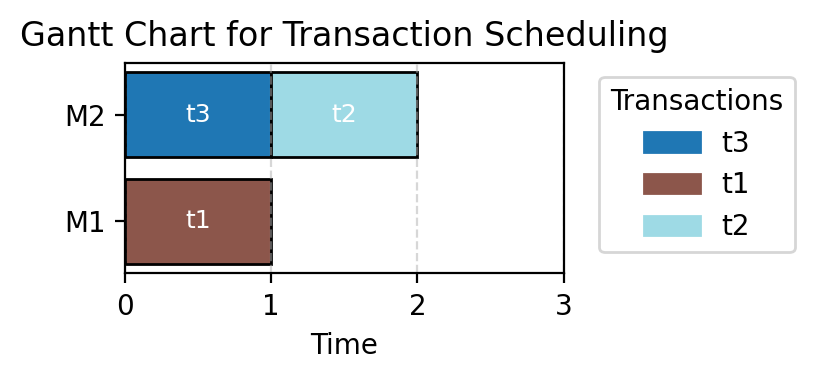

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
total_runtime = 3
schedule_rq  = schedule_rq
# Assign unique colors to transactions
transactions = {t[0] for tasks in schedule_rq.values() for t in tasks}
colors = plt.cm.get_cmap('tab20', len(transactions))
color_map = {txn: colors(i) for i, txn in enumerate(transactions)}

# Create the plot
fig, ax = plt.subplots(figsize=(4, 2), dpi=200)

for i, (machine, tasks) in enumerate(schedule_rq.items()):
    for task in tasks:
        txn, start, duration = task
        ax.barh(machine, duration, left=start, color=color_map[txn], edgecolor='black')
        ax.text(start + duration / 2, i, txn, va='center', ha='center', color='white', fontsize=9)

# Set limits and labels
ax.set_xlim(0, total_runtime)
ax.set_xlabel("Time")
ax.set_title("Gantt Chart for Transaction Scheduling")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# Legend
handles = [mpatches.Patch(color=color_map[txn], label=txn) for txn in color_map]
ax.legend(handles=handles, title="Transactions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()